Simply debias BERT by optimizing the log odds ratio

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

import pandas as pd
import numpy as np
from pathlib import Path
from typing import *
import matplotlib.pyplot as plt
from overrides import overrides
%matplotlib inline

In [3]:
import sys
sys.path.append("../lib")

In [4]:
from bert_utils import Config, BertPreprocessor
config = Config(
    model_type="bert-base-uncased",
    max_seq_len=24,
    batch_size=32,
    bias_weight=1., # technically unnecessary, but for easier debugging
    consistency_weight=1.5,
    lr=5e-6,
    weight_reg=1e-4,
    disable_dropout=True,
    init_probs_precomputed=True,
    testing=True,
    remove_prior_bias=True,
    epochs=10,
)

Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex.


In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
T = TypeVar("T")
TensorDict = Dict[str, Union[torch.Tensor, Dict[str, torch.Tensor]]]

In [7]:
processor = BertPreprocessor(config.model_type, config.max_seq_len)

In [8]:
DATA_ROOT = Path("../data")
MODEL_SAVE_DIR = Path("../weights")

Read the model in here

In [9]:
from pytorch_pretrained_bert import BertConfig, BertForMaskedLM
masked_lm = BertForMaskedLM.from_pretrained(config.model_type)
masked_lm.eval()

BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1)
            )
          )
          (intermediate): BertIntermediate(
       

Dropout might be causing the model to be more uncertain, attributing lower probs to the correct sentence: disabling might help with logit explosion

In [10]:
if config.disable_dropout:
    def disable_dropout(mod):
        if hasattr(mod, "named_children"):
            for nm, child in mod.named_children():
                if "dropout" in nm: child.p = 0. # forcibly set to 0
                disable_dropout(child)
    disable_dropout(masked_lm)

In [11]:
masked_lm

BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.0)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.0)
            )
          )
          (intermediate): BertIntermediate(
       

Freeze positional embeddings

In [12]:
masked_lm.bert.embeddings.position_embeddings.requires_grad = False
masked_lm.bert.embeddings.token_type_embeddings.requires_grad = False

Freeze layer norm

In [13]:
for k, v in masked_lm.named_parameters():
    if "LayerNorm" in k: v.requires_grad = False

# The Dataset

In [14]:
from allennlp.data.token_indexers import PretrainedBertIndexer

def flatten(x: List[List[T]]) -> List[T]:
        return [item for sublist in x for item in sublist]

token_indexer = PretrainedBertIndexer(
    pretrained_model=config.model_type,
    max_pieces=config.max_seq_len,
    do_lowercase=True,
 )

def tokenizer(s: str):
    maxlen = config.max_seq_len - 2
    toks = token_indexer.wordpiece_tokenizer(s)[:maxlen]
    return toks

In [15]:
def to_np(t): return t.detach().cpu().numpy()

def to_words(arr):
    if len(arr.shape) > 1:
        return [to_words(a) for a in arr]
    else:
        arr = to_np(arr)
        return " ".join([itot(i) for i in arr])

In [16]:
rev_vocab = {v: k for k, v in token_indexer.vocab.items()}

def ttoi(t: str): return token_indexer.vocab[t]
def itot(i: int): return rev_vocab[i]

In [17]:
from allennlp.data.vocabulary import Vocabulary
global_vocab = Vocabulary()

### Dataset

In [18]:
import csv
from allennlp.data import DatasetReader, Instance, Token
from allennlp.data.fields import (TextField, SequenceLabelField, LabelField, 
                                  MetadataField, ArrayField)

class BertTextField(TextField):
    @overrides
    def get_padding_lengths(self): # consistent padding lengths
        pad_lengths = super().get_padding_lengths()
        for k in pad_lengths.keys():
            pad_lengths[k] = config.max_seq_len
        return pad_lengths

class LongArrayField(ArrayField):
    @overrides
    def as_tensor(self, padding_lengths: Dict[str, int]) -> torch.Tensor:
        tensor = torch.from_numpy(self.array)
        return tensor
    
class FloatArrayField(ArrayField):
    @overrides
    def as_tensor(self, padding_lengths: Dict[str, int]) -> torch.FloatTensor:
        tensor = torch.FloatTensor(self.array)
        return tensor

class DebiasingDatasetReader(DatasetReader):
    def __init__(self, tokenizer, token_indexers, 
                 init_probs_precomputed: bool=False,
                 remove_prior_bias: bool=False,
                 ) -> None:
        super().__init__(lazy=False)
        self.tokenizer = tokenizer
        self.token_indexers = token_indexers
        self.vocab = token_indexers["tokens"].vocab
        self._init_probs_precomputed = init_probs_precomputed
        self._remove_prior_bias = remove_prior_bias

    def _proc(self, x):
        if x == "[MASK]" or x == "[PAD]": return x
        else: return x.lower()
        
    @overrides
    def text_to_instance(self, tokens: List[str], w1: str, w2: str, 
                         p1: Optional[float], p2: Optional[float],
                         desired_bias: Optional[float],
                        ) -> Instance:
        fields = {}
        input_toks = [Token(self._proc(x)) for x in tokens]
        fields["input"] = BertTextField(input_toks, self.token_indexers)        
        # take [CLS] token into account
        mask_position = tokens.index("[MASK]") + 1
        fields["mask_positions"] = LongArrayField(
            np.array(mask_position, dtype=np.int64),
         )
        fields["target_ids"] = LongArrayField(np.array([
            self.vocab[w1], self.vocab[w2],
        ], dtype=np.int64))
                
        if self._init_probs_precomputed:
            fields["initial_prob_sum"] = FloatArrayField(np.array(p1 + p2, dtype=np.float32))
        else:
            with torch.no_grad():
                bert_input = (self.token_indexers["tokens"]
                              .tokens_to_indices(input_toks, global_vocab, "tokens"))
                token_ids = torch.LongTensor(bert_input["tokens"]).unsqueeze(0)
                probs = masked_lm(token_ids)[0, mask_position, :].detach().numpy()
                probs = (probs - probs.max())
                probs = probs.exp() / probs.exp().sum()
                fields["initial_prob_sum"] = \
                    FloatArrayField(np.array(probs[self.vocab[w1]] + probs[self.vocab[w2]],
                               dtype=np.float32))
            
        if self._remove_prior_bias:
            fields["desired_bias"] = \
                FloatArrayField(np.array(desired_bias, dtype=np.float32))
        
        return Instance(fields)
    
    @overrides
    def _read(self, file_path: str) -> Iterator[Instance]:
        p1, p2 = 0., 0.
        with open(file_path, "rt") as f:
            reader = csv.reader(f)
            for row in reader:
                if self._init_probs_precomputed: sentence, w1, w2, tgt, p1, p2, prior_bias = row
                else: sentence, w1, w2, tgt = row
                yield self.text_to_instance(
                    self.tokenizer(sentence), 
                    w1, w2, # words
                    float(p1), float(p2), # initial probs
                    float(prior_bias), # prior bias
                )

In [19]:
reader = DebiasingDatasetReader(tokenizer=tokenizer, 
                                token_indexers={"tokens": token_indexer},
                                init_probs_precomputed=config.init_probs_precomputed,
                                remove_prior_bias=config.remove_prior_bias)
train_ds, val_ds = (reader.read(DATA_ROOT / fname) for fname in ["sample_w_probs.csv", "sample_w_probs.csv"])

72it [00:00, 14742.00it/s]
72it [00:00, 21951.73it/s]


In [20]:
vars(train_ds[0].fields["input"])

{'tokens': [[MASK], is, a, nurse],
 '_token_indexers': {'tokens': <allennlp.data.token_indexers.wordpiece_indexer.PretrainedBertIndexer at 0x1a34d1e9e8>},
 '_indexed_tokens': None,
 '_indexer_name_to_indexed_token': None}

### Data Iterator

In [21]:
from allennlp.data.iterators import BasicIterator

iterator = BasicIterator(
        batch_size=config.batch_size, 
    )
iterator.index_with(global_vocab)

Sanity check

In [22]:
batch = next(iter(iterator(train_ds)))

In [23]:
batch

{'input': {'tokens': tensor([[  101,   103,  2003,  1037,  2269,   102,     0,     0,     0,     0,
               0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
               0,     0,     0,     0],
          [  101,   103,  2003,  6355,   102,     0,     0,     0,     0,     0,
               0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
               0,     0,     0,     0],
          [  101,   103,  2003,  1037,  2269,   102,     0,     0,     0,     0,
               0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
               0,     0,     0,     0],
          [  101,   103,  2003,  1037,  2269,   102,     0,     0,     0,     0,
               0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
               0,     0,     0,     0],
          [  101,   103,  2003,  6355,   102,     0,     0,     0,     0,     0,
               0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
           

# Model and Loss

### The loss function

In [24]:
def mse_loss(x, y, desired=0): return ((x - y - desired) ** 2).mean()
def mae_loss(x, y, desired=0): return (x - y - desired).abs().mean()
class HingeLoss(nn.Module):
    def __init__(self, margin: float=0.1):
        super().__init__()
        self.margin = margin
    def forward(self, x, y, desired=0.):
        return torch.relu((x - y - desired).abs().mean() - self.margin)

In [25]:
def neg_likelihood(ll, # (batch, )
               initial_prob_sum, # (batch, )
     ):
    """log likelihood of either of the target ids being chosen"""
    return -ll.mean()

class LogitConsistency(nn.Module):
    def __init__(self, distance: Callable):
        super().__init__()
        self._distance = distance
    
    def forward(self, ll, # (batch, )
                initial_prob_sum, # (batch, )
               ):
        """
        Constrains prob sum put on two words to be roughly equal
        TODO: Provide some probabilistic/statistical interpretation
        """
        d = self._distance(ll, initial_prob_sum.log())
        return d

In [26]:
from allennlp.training.metrics import Metric
class TotalProbDiff(Metric):
    def __init__(self):
        super().__init__()
        self._total = 0
        self._n_obs = 0
        
    def __call__(self, ll, initial_prob_sum):
        self._total += (ll.exp() - initial_prob_sum).mean().item()
        self._n_obs += 1
        
    def get_metric(self, reset: bool=False):
        mtrc = self._total / self._n_obs
        if reset: self.reset()
        return mtrc
    
    def reset(self):
        self._total = 0
        self._n_obs = 0

In [27]:
class BiasLoss(nn.Module):
    """
    Returns the deviation of the log odds ratio from its desired value.
    Denoting the probs as p and q there are several options available:
        - MSE(log p, log q)
        - Max-margin loss
    Most processing takes place here because there is a lot of shared heavy processing required
    (e.g. computing partition function)
    TODO: Add option to set the optimal log odds ratio
    TODO: Ensure the logits do not change significantly
    """
    def __init__(self, loss_func: Callable=mae_loss,
                 consistency_loss_func: Callable=LogitConsistency(mae_loss),
                 bias_weight: float=1.,
                 consistency_weight: float=1.):
        super().__init__()
        self.loss_func = loss_func
        self._consistency_loss = consistency_loss_func
        self.consistency_weight = consistency_weight
        self.bias_weight = bias_weight
        self._total_prob_diff = TotalProbDiff()
    
    @staticmethod
    def _log_likelihood(logits, # (batch, V)
                        target_logits, # (batch, )
                       ) -> torch.FloatTensor: # (batch, )
        max_logits = logits.max(1, keepdim=True)[0] # (batch, )
        log_exp_sum_logits = ((logits - max_logits).exp()
                              .sum(1).log()) # (batch, )
        # these logits should never be masked
        log_exp_sum_correct_logits = ((target_logits - max_logits).exp()
                                      .sum(1).log()) # (batch, )
        return log_exp_sum_correct_logits - log_exp_sum_logits
        
    def forward(self, logits: torch.FloatTensor, # (batch, seq, V)
                mask_positions: torch.LongTensor, # (batch, )
                target_ids: torch.LongTensor, # (batch, 2)
                initial_prob_sum: torch.FloatTensor, # (batch, )
                desired_bias: torch.FloatTensor=None,
               ) -> torch.FloatTensor:
        """
        input_ids: Numericalized tokens
        mask_position: Positions of mask tokens
        target_ids: Ids of target tokens to compute log odds on
        padding_mask: padding positions
        """
        bs, seq = logits.size(0), logits.size(1)

        # Gather the logits for at the masked positions
        # TODO: More efficient implementation?
        # Gather copies the data to create a new tensor which we would rather avoid
        sel = (mask_positions.unsqueeze(1)
                .unsqueeze(2).expand(bs, 1, logits.size(2))) # (batch, 1, V)
        logits_at_masked_positions = logits.gather(1, sel).squeeze(1) # (batch, V)
        
        # Gather the logits for the target ids
        sel = target_ids
        target_logits_at_masked_positions = logits_at_masked_positions.gather(1, sel).squeeze(1) # (batch, 2)
        
        bias_loss = self.loss_func(
            target_logits_at_masked_positions[:, 0], # male logits
            target_logits_at_masked_positions[:, 1], # female logits
            desired=desired_bias if desired_bias is not None else 0.,
         )
        
        # compute log likelihood of either of the target ids being observed
        ll = self._log_likelihood(logits_at_masked_positions,
                                  target_logits_at_masked_positions)
        
        # enforce consistency between prior probabilities and current probabilities
        consistency_loss = self._consistency_loss(
            ll, initial_prob_sum,
         )
        out_dict = {}
        out_dict["bias_loss"] = bias_loss * self.bias_weight
        out_dict["consistency_loss"] = consistency_loss * self.consistency_weight
        out_dict["loss"] = out_dict["bias_loss"] + out_dict["consistency_loss"]
        out_dict["total_prob_diff"] = self._total_prob_diff(ll, initial_prob_sum)
        return out_dict

    def get_metrics(self, reset: bool = False) -> Dict[str, float]:
        return {"total_prob_diff": self._total_prob_diff.get_metric(reset)}

Sanity checks

In [28]:
to_words(batch["input"]["tokens"])

['[CLS] [MASK] is a father [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]',
 '[CLS] [MASK] is violent [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]',
 '[CLS] [MASK] is a father [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]',
 '[CLS] [MASK] is a father [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]',
 '[CLS] [MASK] is violent [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]',
 '[CLS] [MASK] is married [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]',
 '[CLS] [MASK] is beautiful [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PA

In [29]:
batch

{'input': {'tokens': tensor([[  101,   103,  2003,  1037,  2269,   102,     0,     0,     0,     0,
               0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
               0,     0,     0,     0],
          [  101,   103,  2003,  6355,   102,     0,     0,     0,     0,     0,
               0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
               0,     0,     0,     0],
          [  101,   103,  2003,  1037,  2269,   102,     0,     0,     0,     0,
               0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
               0,     0,     0,     0],
          [  101,   103,  2003,  1037,  2269,   102,     0,     0,     0,     0,
               0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
               0,     0,     0,     0],
          [  101,   103,  2003,  6355,   102,     0,     0,     0,     0,     0,
               0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
           

In [30]:
bias_loss = BiasLoss()
logits = masked_lm(batch["input"]["tokens"])
bias_loss(logits, batch["mask_positions"], batch["target_ids"],
          batch["initial_prob_sum"])

{'bias_loss': tensor(1.2698, grad_fn=<MulBackward0>),
 'consistency_loss': tensor(1.0417e-06, grad_fn=<MulBackward0>),
 'loss': tensor(1.2698, grad_fn=<AddBackward0>),
 'total_prob_diff': None}

In [31]:
probs = torch.softmax(logits[:, 1, :], 1)

In [32]:
sentence, w1, w2 = "[MASK] is a nurse", "he", "she"

tokens = tokenizer(sentence)
mask_position = tokens.index("[MASK]") + 1
input_toks = [Token(w) for w in tokens]
bert_input = (token_indexer.tokens_to_indices(input_toks, global_vocab, "tokens"))
token_ids = torch.LongTensor(bert_input["tokens"]).unsqueeze(0)

In [33]:
probs[:, token_indexer.vocab[w1]] + probs[:, token_indexer.vocab[w2]]

tensor([0.7182, 0.0818, 0.7182, 0.7182, 0.0818, 0.8944, 0.0845, 0.8434, 0.8479,
        0.5886, 0.8479, 0.7507, 0.7476, 0.7476, 0.7507, 0.6489, 0.0513, 0.7182,
        0.8479, 0.7182, 0.8944, 0.7476, 0.6489, 0.7507, 0.7182, 0.0845, 0.5886,
        0.0845, 0.8944, 0.5886, 0.0818, 0.0513], grad_fn=<AddBackward0>)

In [34]:
batch["initial_prob_sum"]

tensor([0.7182, 0.0818, 0.7182, 0.7182, 0.0818, 0.8944, 0.0845, 0.8434, 0.8479,
        0.5886, 0.8479, 0.7507, 0.7476, 0.7476, 0.7507, 0.6489, 0.0513, 0.7182,
        0.8479, 0.7182, 0.8944, 0.7476, 0.6489, 0.7507, 0.7182, 0.0845, 0.5886,
        0.0845, 0.8944, 0.5886, 0.0818, 0.0513])

### The allennlp model (for training)

In [35]:
from copy import deepcopy

In [39]:
from allennlp.models import Model

class BERT(Model):
    def __init__(self, vocab, bert_for_masked_lm, 
                 loss: nn.Module=BiasLoss()):
        super().__init__(vocab)
        self.bert_for_masked_lm = bert_for_masked_lm
        self.loss = loss
    
    def forward(self, 
                input: TensorDict,
                mask_positions: torch.LongTensor,
                target_ids: torch.LongTensor,
                initial_prob_sum: torch.FloatTensor,
                desired_bias: torch.FloatTensor=None,
            ) -> TensorDict:
        logits = self.bert_for_masked_lm(input["tokens"])
        # most of processing takes place in loss func
        out_dict = self.loss(logits, mask_positions, 
                             target_ids, initial_prob_sum,
                             desired_bias=desired_bias,
                            )
        out_dict["logits"] = logits
        return out_dict
    
    def get_metrics(self, reset: bool=False):
        return self.loss.get_metrics()

In [40]:
logit_distance = mae_loss

loss = BiasLoss(
    loss_func=logit_distance,
    consistency_loss_func=LogitConsistency(logit_distance),
    bias_weight=config.bias_weight,
    consistency_weight=config.consistency_weight,
)
model = BERT(global_vocab, masked_lm, loss=loss)

In [41]:
init_dict = dict(model.state_dict())

In [42]:
model.load_state_dict(init_dict)

In [43]:
orig_weights = {k: deepcopy(v) for k, v in model.named_parameters()}

### Bias scores before

In [44]:
masked_lm.eval()
logits = masked_lm(processor.to_bert_model_input("[MASK] is a housemaid"))[0, 1]

In [45]:
logits[ttoi("he")]

tensor(8.1598, grad_fn=<SelectBackward>)

In [46]:
logits[ttoi("she")]

tensor(8.8144, grad_fn=<SelectBackward>)

In [47]:
probs = torch.softmax(logits.unsqueeze(0), 1).squeeze(0)

In [48]:
probs[ttoi("he")]

tensor(0.2187, grad_fn=<SelectBackward>)

In [49]:
probs[ttoi("she")]

tensor(0.4208, grad_fn=<SelectBackward>)

For word not in vocab

In [50]:
logits = masked_lm(processor.to_bert_model_input("[MASK] is a slut"))[0, 1]

In [51]:
logits[ttoi("he")]

tensor(7.7761, grad_fn=<SelectBackward>)

In [52]:
logits[ttoi("she")]

tensor(8.8424, grad_fn=<SelectBackward>)

In [53]:
probs = torch.softmax(logits.unsqueeze(0), 1).squeeze(0)

In [54]:
probs[ttoi("he")]

tensor(0.1566, grad_fn=<SelectBackward>)

In [55]:
probs[ttoi("she")]

tensor(0.4547, grad_fn=<SelectBackward>)

### Probability distribution for unrelated sentence

In [56]:
def print_topk_preds(masked_sentence, k=5, strlen=30):
    mask_idx = [x.text for x in processor.tokenize(masked_sentence)].index("[MASK]") + 1
    logits = masked_lm(processor.to_bert_model_input(masked_sentence))
    probs = torch.softmax(logits.squeeze(0), 1)
    topk = []
    for p, id_ in zip(*probs[mask_idx, :].topk(k)):
        topk.append(("%.4f" % p.item(), itot(id_.item())))
    print("\n".join([f"{masked_sentence.replace('[MASK]', w)}:{' ' * (strlen - len(w) - len(p))}{p}" for p, w in topk]))

In [57]:
print_topk_preds("i ride my [MASK] to work")

i ride my bike to work:                    0.6130
i ride my motorcycle to work:              0.0891
i ride my car to work:                     0.0659
i ride my bus to work:                     0.0620
i ride my bicycle to work:                 0.0207


In [58]:
print_topk_preds("the [MASK] wagged its tail")

the dog wagged its tail:                     0.3024
the cat wagged its tail:                     0.0879
the bird wagged its tail:                    0.0463
the wolf wagged its tail:                    0.0325
the creature wagged its tail:                0.0312


In [59]:
print_topk_preds("the fish [MASK] through the water")

the fish swam through the water:                    0.1042
the fish flew through the water:                    0.0561
the fish sailed through the water:                  0.0507
the fish ran through the water:                     0.0467
the fish raced through the water:                   0.0463


# Training Loop

In [60]:
from allennlp.training import Callback

In [61]:
from copy import deepcopy

class StatisticRecorder(Callback):
    def __init__(self, orig_weights, rec_periods=1):
        self.rec_periods = rec_periods
        self.norms = {k: [] for k, v in model.named_parameters() if v.requires_grad}
        self.grad_magnitudes = {k: [] for k, v in model.named_parameters() if v.requires_grad}
        self._orig_weights = orig_weights
        self.change_magnitudes = {k: [] for k, v in model.named_parameters() if v.requires_grad}
        
    def on_batch_end(self, data):
        if (data['batches_this_epoch'] + 1) % self.rec_periods == 0:
            with torch.no_grad():
                for k, p in self.trainer.model.named_parameters():
                    if p.requires_grad and p.grad is not None:
                        Z = torch.norm(p).item()
                        self.norms[k].append(Z)
                        self.grad_magnitudes[k].append((torch.norm(p.grad) / Z).item())
                        self.change_magnitudes[k].append((torch.norm(p - self._orig_weights[k]) / Z).item())

In [62]:
class WeightDeviationRegularizor(Callback):
    def __init__(self, orig_weights, weight=1e-4, l1=True):
        self.orig_weights = orig_weights
        self.weight = weight
        self.l1 = l1
        
    def get_reg_term(self, now, orig):
        if self.l1:
            return torch.where(now < orig, torch.ones_like(now), -torch.ones_like(now))
        else:
            return (orig - now)
        
    def on_backward_end(self, data):
        lr = config.lr
        with torch.no_grad():
            for name, param in self.trainer.model.named_parameters():
                if param.requires_grad and param.grad is not None:
                    reg_term = self.weight * lr * self.get_reg_term(param.data, orig_weights[name])
                    param.data.add_(reg_term)

In [63]:
from collections import defaultdict
class LossMonitor(Callback):
    def __init__(self):
        super().__init__()
        self.logs = defaultdict(list)
    def on_forward_end(self, payload):
        for k, v in payload.items():
            if "loss" in k: self.logs[k].append(v.item())

In [64]:
stat_rec = StatisticRecorder(orig_weights, rec_periods=1)
wdd = WeightDeviationRegularizor(orig_weights, weight=config.weight_reg)
monitor = LossMonitor()

In [65]:
def use(name: str):
    if "LayerNorm" in name: return False
    if "position_embeddings" in name: return False
    if "token_type" in name: return False
    return True

In [66]:
filtered_params = [p for name, p in model.named_parameters() if use(name)]

In [67]:
from allennlp.training import TrainerWithCallbacks

optimizer = torch.optim.Adam(filtered_params, lr=config.lr, weight_decay=0.)

trainer = TrainerWithCallbacks(
    model=model,
    optimizer=optimizer,
    iterator=iterator,
    train_dataset=train_ds,
    validation_dataset=val_ds,
    callbacks=[stat_rec, wdd, monitor],
#     serialization_dir=DATA_ROOT / "debias_ckpts",
    cuda_device=0 if torch.cuda.is_available() else -1,
    num_epochs=config.epochs,
)

You provided a validation dataset but patience was set to None, meaning that early stopping is disabled


In [68]:
trainer.train()

total_prob_diff: 0.0503, loss: 1.1820 ||: 100%|██████████| 3/3 [00:17<00:00,  6.12s/it] 
total_prob_diff: 0.0244, loss: 0.8154 ||: 100%|██████████| 3/3 [00:03<00:00,  1.10s/it]
total_prob_diff: 0.0009, loss: 0.6662 ||: 100%|██████████| 3/3 [00:18<00:00,  6.55s/it]
total_prob_diff: -0.0043, loss: 0.7536 ||: 100%|██████████| 3/3 [00:03<00:00,  1.17s/it]
total_prob_diff: 0.0006, loss: 0.7062 ||: 100%|██████████| 3/3 [00:18<00:00,  6.43s/it] 
total_prob_diff: 0.0059, loss: 0.5566 ||: 100%|██████████| 3/3 [00:03<00:00,  1.13s/it]
total_prob_diff: 0.0108, loss: 0.3748 ||: 100%|██████████| 3/3 [00:18<00:00,  6.20s/it]
total_prob_diff: 0.0129, loss: 0.3398 ||: 100%|██████████| 3/3 [00:03<00:00,  1.06s/it]
total_prob_diff: 0.0137, loss: 0.3481 ||: 100%|██████████| 3/3 [00:17<00:00,  6.15s/it]
total_prob_diff: 0.0113, loss: 0.3226 ||: 100%|██████████| 3/3 [00:02<00:00,  1.04s/it]
total_prob_diff: 0.0081, loss: 0.2712 ||: 100%|██████████| 3/3 [00:17<00:00,  5.94s/it]
total_prob_diff: 0.0039, loss

{'best_epoch': 9,
 'peak_cpu_memory_MB': 4858.974208,
 'training_duration': '00:03:31',
 'training_start_epoch': 0,
 'training_epochs': 9,
 'epoch': 9,
 'training_total_prob_diff': 0.005663819227106215,
 'training_loss': 0.1780108114083608,
 'training_cpu_memory_MB': 4858.974208,
 'validation_total_prob_diff': 0.005292217949560533,
 'validation_loss': 0.15616458157698312,
 'best_validation_total_prob_diff': 0.005292217949560533,
 'best_validation_loss': 0.15616458157698312}

Analyzing changes

In [69]:
change_sorted_weights = sorted([(-v[-1], k) for k, v in stat_rec.change_magnitudes.items() if len(v) > 0])
{k.replace("bert_for_masked_lm.bert.encoder.", ""): -x for x, k in change_sorted_weights}

{'layer.11.attention.self.value.bias': 0.0012676981277763844,
 'layer.4.attention.self.value.bias': 0.0010359497973695397,
 'layer.5.attention.self.value.bias': 0.001024190103635192,
 'layer.2.attention.output.dense.weight': 0.0009708003490231931,
 'layer.2.attention.self.value.weight': 0.0009390335762873292,
 'layer.1.attention.self.value.weight': 0.0009126748191192746,
 'layer.3.attention.output.dense.weight': 0.0009073419496417046,
 'layer.1.attention.output.dense.weight': 0.0009054329129867256,
 'layer.7.attention.output.dense.weight': 0.0008800418581813574,
 'layer.6.attention.output.dense.weight': 0.0008727963431738317,
 'layer.0.attention.output.dense.weight': 0.0008703200146555901,
 'layer.7.attention.self.value.weight': 0.00085807143477723,
 'layer.4.attention.output.dense.weight': 0.0008501105476170778,
 'layer.10.attention.self.value.bias': 0.0008478760719299316,
 'layer.5.attention.output.dense.weight': 0.0008430336019955575,
 'layer.3.attention.self.value.weight': 0.000835

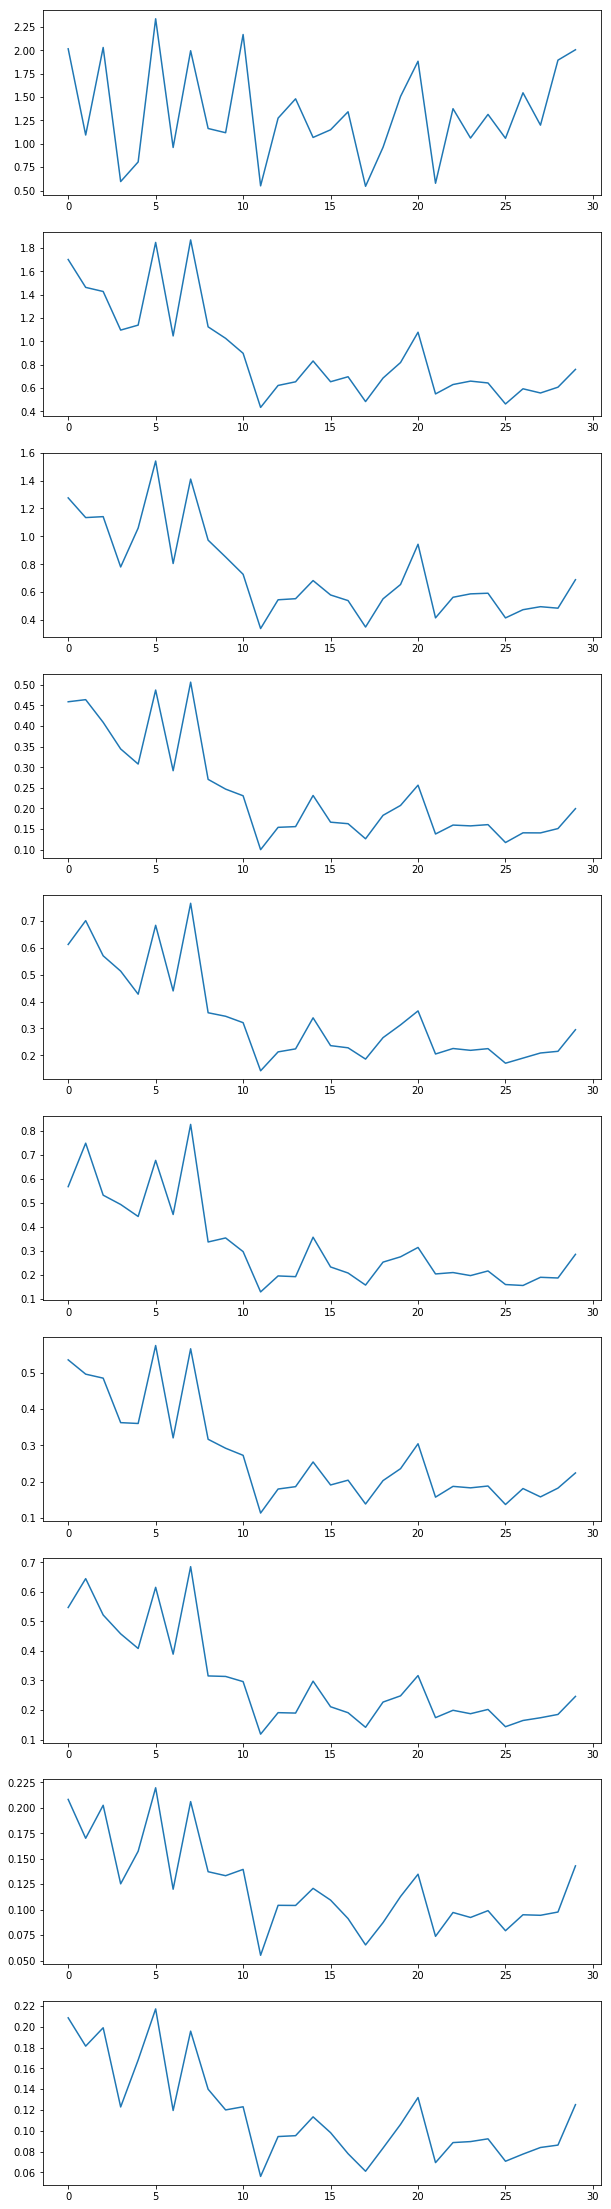

In [70]:
n = 10
fig = plt.figure(figsize=(10, n * 4))
for i, (_, k) in enumerate(change_sorted_weights[:n]):
    ax = fig.add_subplot(n, 1, i+1)
    ax.plot(stat_rec.grad_magnitudes[k])

### Change in loss breakdown

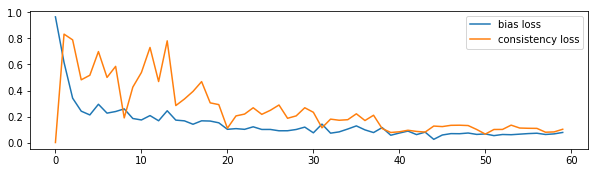

In [71]:
fig = plt.figure(figsize=(10, 30))
ax = fig.add_subplot(n, 1, 1)
ax.plot(monitor.logs["bias_loss"], label="bias loss")
ax.plot(monitor.logs["consistency_loss"], label="consistency loss")
ax.legend()

# Evaluate

Simple prediction

In [72]:
def get_preds(model, batch: TensorDict):
    return model(**batch)["logits"].argmax(2)

In [73]:
to_words(batch["input"]["tokens"])

['[CLS] [MASK] is a father [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]',
 '[CLS] [MASK] is violent [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]',
 '[CLS] [MASK] is a father [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]',
 '[CLS] [MASK] is a father [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]',
 '[CLS] [MASK] is violent [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]',
 '[CLS] [MASK] is married [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]',
 '[CLS] [MASK] is beautiful [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PA

In [74]:
to_words(get_preds(model, batch))

['. he is a . . rv antibodies ##¨ ##ф antibodies antibodies ##¨ ##¨ ##¨ ##¨ ##¨ ##¨ ##¨ ##¨ ##¨ ##¨ ##¨ ##¨',
 '. it is . . rv antibodies ##¨ ##¨ antibodies antibodies ##¨ ##¨ ##¨ ##¨ ##¨ ##¨ ##¨ ##¨ ##¨ ##¨ ##¨ ##¨ ##¨',
 '. he is a . . rv antibodies ##¨ ##ф antibodies antibodies ##¨ ##¨ ##¨ ##¨ ##¨ ##¨ ##¨ ##¨ ##¨ ##¨ ##¨ ##¨',
 '. he is a . . rv antibodies ##¨ ##ф antibodies antibodies ##¨ ##¨ ##¨ ##¨ ##¨ ##¨ ##¨ ##¨ ##¨ ##¨ ##¨ ##¨',
 '. it is . . rv antibodies ##¨ ##¨ antibodies antibodies ##¨ ##¨ ##¨ ##¨ ##¨ ##¨ ##¨ ##¨ ##¨ ##¨ ##¨ ##¨ ##¨',
 '. he is . . rv ##ф ##¨ ##¨ ##ф antibodies ##¨ ##¨ ##¨ ##¨ ##¨ ##¨ ##¨ ##¨ ##¨ ##¨ ##¨ ##¨ ##¨',
 '. it . . . rv antibodies ##¨ ##¨ ##ф ##¨ ##¨ ##¨ ##¨ ##¨ ##¨ ##¨ ##¨ ##¨ ##¨ ##¨ ##¨ ##¨ ##¨',
 '. he is a . . rv ##¦ ##¦ ##¦ antibodies ##¨ ##¦ ##¨ ##¨ ##¨ ##¨ ##¨ ##¦ ##¨ ##¨ ##¨ ##¨ ##¨',
 '. he is a . . rv ##¨ ##¨ ##ф antibodies antibodies ##¨ ##¨ ##¨ ##¨ ##¨ ##¨ ##¨ ##¨ ##¨ ##¨ ##¨ ##¨',
 '. he is a . . rv antibodies ##¨ antibodies antibod

### Logits and bias

In [75]:
masked_lm.eval()
logits = masked_lm(processor.to_bert_model_input("[MASK] is a housemaid"))[0, 1]

In [76]:
logits[ttoi("he")]

tensor(8.7386, grad_fn=<SelectBackward>)

In [77]:
logits[ttoi("she")]

tensor(8.2048, grad_fn=<SelectBackward>)

Probabilities

In [78]:
probs = torch.softmax(logits.unsqueeze(0), 1).squeeze(0)

In [79]:
probs[ttoi("he")]

tensor(0.4367, grad_fn=<SelectBackward>)

In [80]:
probs[ttoi("she")]

tensor(0.2561, grad_fn=<SelectBackward>)

##### For an example not in the vocabulary

In [81]:
logits = masked_lm(processor.to_bert_model_input("[MASK] is a slut"))[0, 1]

In [82]:
logits[ttoi("he")]

tensor(8.3554, grad_fn=<SelectBackward>)

In [83]:
logits[ttoi("she")]

tensor(8.0636, grad_fn=<SelectBackward>)

In [84]:
probs = torch.softmax(logits.unsqueeze(0), 1).squeeze(0)

In [85]:
probs[ttoi("he")]

tensor(0.3502, grad_fn=<SelectBackward>)

In [86]:
probs[ttoi("she")]

tensor(0.2616, grad_fn=<SelectBackward>)

Why do the probabilities blow up??

Changes to output distribution of unrelated sentences

In [87]:
print_topk_preds("i ride my [MASK] to work")

i ride my bike to work:                    0.5769
i ride my motorcycle to work:              0.0797
i ride my car to work:                     0.0732
i ride my bus to work:                     0.0679
i ride my bicycle to work:                 0.0193


In [88]:
print_topk_preds("the [MASK] wagged its tail")

the dog wagged its tail:                     0.2589
the cat wagged its tail:                     0.0784
the bird wagged its tail:                    0.0468
the creature wagged its tail:                0.0356
the wolf wagged its tail:                    0.0337


In [89]:
print_topk_preds("the fish [MASK] through the water")

the fish swam through the water:                    0.0960
the fish flew through the water:                    0.0583
the fish ran through the water:                     0.0502
the fish sailed through the water:                  0.0441
the fish raced through the water:                   0.0411


# Export Weights

As PyTorch state dict

In [87]:
torch.save(masked_lm.state_dict(), MODEL_SAVE_DIR / "state_dict.pth")

TODO: Export as tensorflow checkpoint?